C:\Users\dinsoson\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in divide
C:\Users\dinsoson\Anaconda2\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater


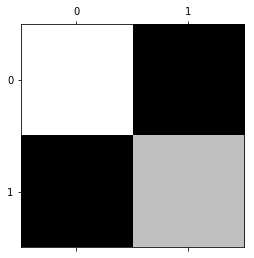

In [1]:
import numpy as np
import pandas as pd
from StringIO import StringIO
#==================================set features===================================================================
class extract_features:
    def __init__(self, filename):
        self.filename = filename
        a = open(filename)
        t = a.read()
        a.close()
        depth_index = t.find('DEPTH IN CM')
        t = t[depth_index:]
        zeta_index = t.find('ZETA')
        d = t[:zeta_index]
        d = d[:d.find('W')]
        t = t[zeta_index:]
        self.text = t
        self.W_index = t.find('W')
        self.depth = d
    
    def properties(self):
        return pd.read_csv(StringIO(self.text[self.W_index:]),sep='\s+')
    
    def zetas(self):
        zeta = pd.read_csv(StringIO(self.text[:self.W_index]), header=None, sep='\s+', skiprows=1)
        z = zeta.values
        zeta_val = z.ravel()
        zeta_val = zeta_val[~np.isnan(zeta_val)]
        # times of zeta crosses 0
        zeta0 = sum(np.diff(np.sign(zeta_val)) != 0)
        # times of dzeta crosses 0
        dz = np.gradient(zeta_val, 1)
        dz0 = sum(np.diff(np.sign(dz)) != 0)
        # shelf break
        de = pd.read_csv(StringIO(self.depth), header=None, sep='\s+', skiprows=1)
        depth_val = de.values.ravel()
        depth_val = depth_val[~np.isnan(depth_val)]
        depth_val = depth_val/depth_val.max()*np.fabs(zeta_val).max()
        depth_val_d = np.diff(depth_val)
        depth_val1 = depth_val_d[1:]
        depth_val1 = np.append(depth_val1, depth_val_d[-1])
        sb = list(depth_val1/depth_val_d > 3).index(1)
        zeta_val_d = np.diff(np.log(np.fabs(zeta_val)))
        wb = np.argmax(np.gradient(zeta_val_d,1)**2)
        dist = float(sb - wb)/len(depth_val)
        return pd.DataFrame(np.array([zeta0,dz0,abs(dist)]).reshape(1,3), columns=['zeta0','dz','wb'])

#======================Find Zeta values and wave properties======================================================
properties = pd.DataFrame([], columns=['W','L','C','RTF'])
# zetas = pd.DataFrame([], columns=['zeta0','dz','shelf break','wb'])
zetas = pd.DataFrame([], columns=['zeta0','dz','wb'])
n = 10 # numbers of training set for 0 mode
for i in range(n):
    s = 'semi{}.txt'.format(i)
    
    # wave properties
    properties = properties.append(extract_features(s).properties())
    properties = properties.reset_index(drop=True)
    
    # zeta
    zetas = zetas.append(extract_features(s).zetas())
    zetas = zetas.reset_index(drop=True)

m = 10 # 1st mode
for i in range(m):
    s = 'w{}.txt'.format(i)
    
    # wave properties
    properties = properties.append(extract_features(s).properties())
    properties = properties.reset_index(drop=True)
    
    # zeta
    zetas = zetas.append(extract_features(s).zetas())
    zetas = zetas.reset_index(drop=True)

l = 10 # 2st mode
for i in range(l):
    s = 'r{}.txt'.format(i)
    
    # wave properties
    properties = properties.append(extract_features(s).properties())
    properties = properties.reset_index(drop=True)
    
    # zeta
    zetas = zetas.append(extract_features(s).zetas())
    zetas = zetas.reset_index(drop=True)
    
k = 10 # complex solution
for i in range(k):
    s = 'q{}.txt'.format(i)
    
    # wave properties
    properties = properties.append(extract_features(s).properties())
    properties = properties.reset_index(drop=True)
    
    # zeta
    zetas = zetas.append(extract_features(s).zetas())
    zetas = zetas.reset_index(drop=True)
#======================Train a model============================================================================
# label
y0 = np.ones(n)
y1 = np.zeros(m)
y2 = np.zeros(l)
y9 = np.zeros(k-1)
y = np.concatenate((y0,y1,y2,y9))
x = zetas.values
y[0] = 0

np.random.seed(21)
shuffled = np.random.permutation(len(y))
x = x[shuffled]
y = y[shuffled]
xtrain = x[:int(len(y)*.8)]
ytrain = y[:int(len(y)*.8)]
xtest = x[int(len(y)*.8):]
ytest = y[int(len(y)*.8):]

from sklearn.svm import SVC
svc_cls=SVC(kernel='rbf', gamma=40, C=100)
svc_cls.fit(xtrain,ytrain)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
yprd = svc_cls.predict(xtest)
cf = confusion_matrix(ytest, yprd)
plt.matshow(cf, cmap=plt.cm.gray)
plt.xticks([0,1],svc_cls.classes_.astype(int).astype(str))
plt.yticks([0,1],svc_cls.classes_.astype(int).astype(str))
plt.show()